In [1]:
from mpl_toolkits.basemap import Basemap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint
import pandas as pd
import numpy as np
import itertools
import operator
import json
import sys

pd.options.display.float_format = '{:.4g}'.format

import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

py.init_notebook_mode(connected=True)

In [2]:
with open("/Users/pavel/Sources/python/concepts/insta/cv_sandbox/age-gender-estimation/gender_ages_moscow.json", "r") as f:
    data = json.load(f) #!

path = "/Users/pavel/Sources/python/concepts/insta/photos_moscow/"
loc_file = list(map(lambda x: x.strip().split(","), open(path + "loc_info.csv", "r").readlines()[1:]))
id2loc = {x[0]: x[1] for x in loc_file}
locations = list(set(list(data)))
ids = list(data.keys())

min_photos = 10
genders_global = []
ages_global = []
dc = 0
for id in locations:
    if id in data:
        genders_data = data[id]['genders']
        ages_data = data[id]['ages']

        genders = list(itertools.chain(*genders_data.values()))
        ages = list(itertools.chain(*ages_data.values()))

        if len(genders_data) > min_photos:
            cnt = len(list(filter(lambda x: x < 0.5, genders)))
            genders_global.append([id,np.mean(genders), cnt])
            ages_global.append([id, np.percentile(ages, 25), np.median(ages), np.percentile(ages, 75)])
        else:
            dc+=1

In [3]:
gender_table = pd.DataFrame(genders_global, columns=['id', 'mean', 'count'])
ages_table = pd.DataFrame(ages_global, columns=['id', '25 per', '50 per', '75 per'])

In [4]:
fn1 = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/photo_tagger/scenes_moscow.json"
fn2 = "/Users/pavel/Sources/python/concepts/insta/cv_sandbox/age-gender-estimation/gender_ages.json"

with open(fn1, "r") as f:
    data1 = json.load(f)
    
with open(fn2, "r") as f:
    data2 = json.load(f)

In [5]:
def relevant_places(tag):
    d = {}
    for loc in list(data1.keys()):
        loc_val = 0
        for photo in data1[loc]:
            val = 0
            if tag in data1[loc][photo]['categories']:
                val = data1[loc][photo]['categories'][tag]
            loc_val += float(val)
        if loc_val > 0:
            d[loc] = loc_val
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)

In [6]:
hist1, bins1 = np.histogram(gender_table['mean'], bins=25)
hist2, bins2 = np.histogram(ages_table['50 per'], bins=25)

data = [go.Bar(x=(bins1[:-1]+bins1[1:])/2, y=hist1,
                marker=dict(color='orange')), 
    
        go.Bar(x=(bins2[:-1]+bins2[1:])/2, y=hist2,
                marker=dict(color='orange'))]

fig = tools.make_subplots(rows=1, cols=2, print_grid=False,
                            subplot_titles=["gender", "age"])

fig['layout'].update(height=200, width=600, 
                        margin=go.layout.Margin(l=30, r=30, t=50, b=50))

fig['layout']['xaxis{0}'.format(1)].update(ticklen=4)
fig['layout']['xaxis{0}'.format(2)].update(ticklen=4)
fig['layout'].update(showlegend=False)

fig.append_trace(data[0], 1,1)
fig.append_trace(data[1], 1,2)

py.iplot(fig, show_link=False)

In [7]:
gender_result = gender_table.sort_values('mean', ascending=True)[['id', 'mean']].values.tolist()
age_result = ages_table.sort_values('25 per', ascending=True)[['id', '25 per']].values.tolist()

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)

scenes_result = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)[:45]

In [8]:
gender_ages_data = pd.merge(gender_table[['mean', 'id']], ages_table[['25 per', 'id']], on='id')

tags = [x[0].split("/")[0] for x in scenes_result]
tags.remove('beauty_salon')
vis_table1 = gender_table

dd = []
for loc in list(data1.keys()):
    cn = Counter()
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)
    dd.append([loc, cn])
    
dd1 = []
for x in dd:
    dd1.append([x[0]] + [x[1][tag] for tag in tags])
    
tags_info = pd.DataFrame(dd1)
tags_info.columns=["id"] + tags

vis_table1 = pd.merge(vis_table1, tags_info, on='id')

#<0.5 male
#>0.5 female

x, y1, y2 = [],[],[]
for tag in tags:
    try:
        val1 = sum(vis_table1[vis_table1['mean']>np.median(vis_table1['mean'])][tag])
        val2 = sum(vis_table1[vis_table1['mean']<=np.median(vis_table1['mean'])][tag])
        if val1 and val2:
            y1.append(val1)
            y2.append(val2)
            x.append(tag)
        else:
            #print(tag)
            pass
    except:
        #print(tag)
        pass

marker_style = dict(color='dodgerblue')

data = [go.Bar(x=x, y=y1, name='female',
                hoverinfo="y", marker=marker_style),
        go.Bar(x=x, y=y2, name='male', opacity=0.5,
                hoverinfo="y", marker=marker_style)]

margin = go.layout.Margin(t=30, b=130, l=50)
               
layout = go.Layout(height=400, width=800, margin=margin,
                   showlegend=True, xaxis=dict(tickangle=-50, color='grey'), 
                   font=dict(size=11), barmode='stack')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, show_link=False)

In [9]:
gender_ages_data = pd.merge(gender_table[['mean', 'id']], ages_table[['25 per', 'id']], on='id')

tags = [x[0].split("/")[0] for x in scenes_result]
tags.remove('beauty_salon')
vis_table1 = ages_table

dd = []
for loc in list(data1.keys()):
    cn = Counter()
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)
    dd.append([loc, cn])
    
dd1 = []
for x in dd:
    dd1.append([x[0]] + [x[1][tag] for tag in tags])
    
tags_info = pd.DataFrame(dd1)
tags_info.columns=["id"] + tags

vis_table1 = pd.merge(vis_table1, tags_info, on='id')

x, y1, y2, y3, y4 = [],[],[],[],[]
for tag in tags:
    try:
        rc = '50 per'
        th1 = np.percentile(vis_table1[rc], 25)
        th2 = np.percentile(vis_table1[rc], 50)
        th3 = np.percentile(vis_table1[rc], 75)
        val1 = sum(vis_table1[vis_table1[rc]<th1][tag])
        val2 = sum(vis_table1[(vis_table1[rc]>=th1) & (vis_table1[rc]<th2)][tag])
        val3 = sum(vis_table1[(vis_table1[rc]>=th2) & (vis_table1[rc]<th3)][tag])
        val4 = sum(vis_table1[vis_table1[rc]>=th3][tag])
        
        if val1 or val2 or val3 or val4:
            y1.append(val1)
            y2.append(val2)
            y3.append(val3)
            y4.append(val4)
            x.append(tag)
        #else:
        #    #print(tag)
        #    pass
    except:
        pass

marker_style = dict(color='lightseagreen')
data = [
        go.Bar(x=x, y=y1, name="x < p<sub>25</sub>",
                hoverinfo="y", marker=marker_style),
    
        go.Bar(x=x, y=y2, name="p<sub>25</sub> < x < p<sub>50</sub>",
                hoverinfo="y", marker=marker_style, opacity=0.75),
    
        go.Bar(x=x, y=y3, name="p<sub>50</sub> < x < p<sub>75</sub>",
                hoverinfo="y", marker=marker_style, opacity=0.5),
    
        go.Bar(x=x, y=y4, name="x > p<sub>75</sub>",
                hoverinfo="y",marker=marker_style, opacity=0.25)
        ]

layout = go.Layout(height=400, width=800, xaxis=dict(tickangle=-50, color='grey'),
                   margin=go.layout.Margin(t=30, b=130,l=50),
                   showlegend=True, font=dict(size=11), barmode='stack')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, show_link=False)

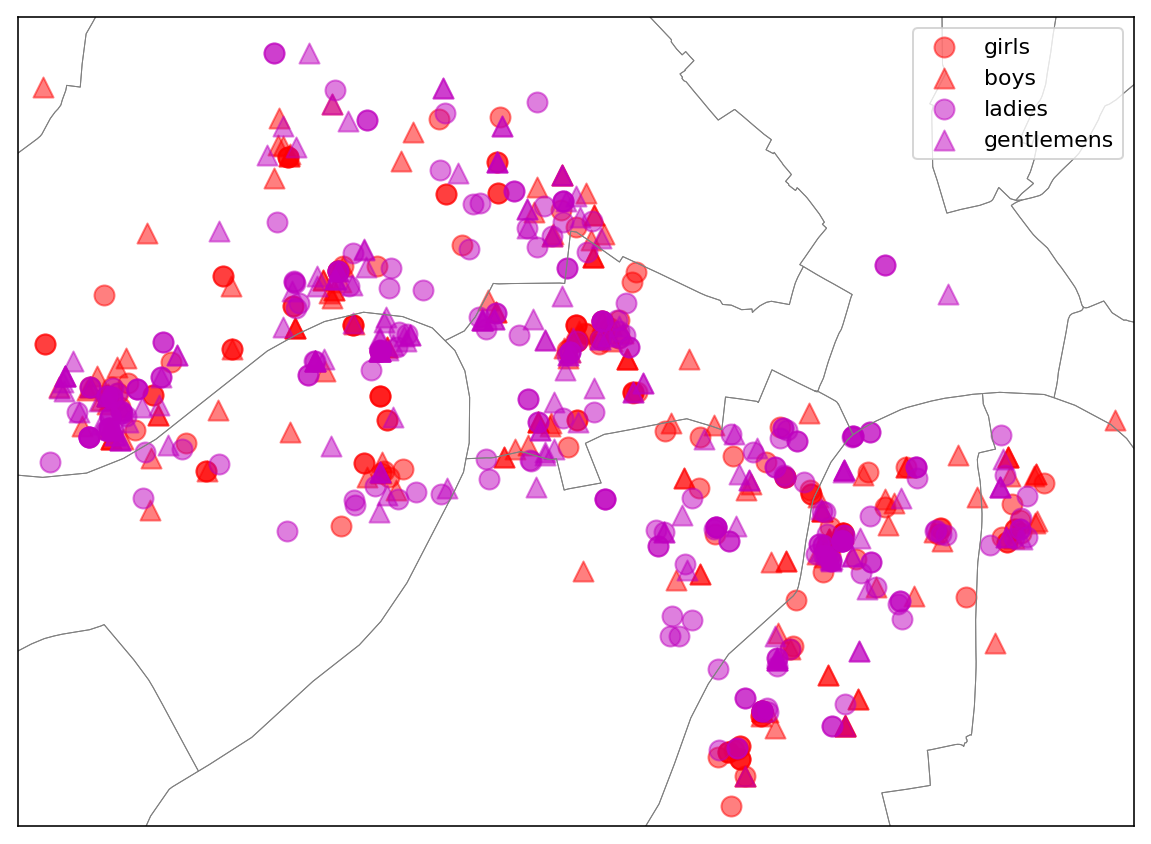

In [10]:
men_marker, women_marker = "^", "o"
young_color, old_color = "r", "m"
m_size = 100
pl_size = 10
alpha = 0.5 

locs = pd.DataFrame([[x[0], float(x[3]), float(x[4])] for x in loc_file], 
                                                columns=["id", "long", "lat"])

map_data = pd.merge(pd.merge(ages_table, gender_table, on='id'), locs, on='id')
  
age_threshold = np.median(map_data['50 per'])
gender_threshold = 0.5

r_name = "50 per"
young_girls = [[line['lat'], line['long']] for _, line in map_data.iterrows() 
                                            if line['mean'] <= gender_threshold 
                                            and line[r_name] <= age_threshold]
young_boys = [[line['lat'], line['long']] for _, line in map_data.iterrows() 
                                            if line['mean'] > gender_threshold 
                                            and line[r_name] <= age_threshold]
old_girls = [[line['lat'], line['long']] for _, line in map_data.iterrows() 
                                            if line['mean'] <= gender_threshold 
                                            and line[r_name] > age_threshold]
old_boys = [[line['lat'], line['long']] for _, line in map_data.iterrows() 
                                            if line['mean'] > gender_threshold 
                                            and line[r_name] > age_threshold]
plt.figure(figsize=(pl_size, pl_size))

geo_map = Basemap(projection='tmerc', llcrnrlat=55.725, urcrnrlat=55.77, 
              llcrnrlon=37.53, urcrnrlon=37.64,
             lon_0=37.6155600, lat_0=55.7522200)

geo_map.readshapefile('../maps/izbirkom_viz-master/atd/mo', 'mo', color='gray')

x_young_girls, y_young_girls = geo_map(*zip(*young_girls))
x_young_boys, y_young_boys = geo_map(*zip(*young_boys))
x_old_girls, y_old_girls = geo_map(*zip(*old_girls))
x_old_boys, y_old_boys = geo_map(*zip(*old_boys))

plt.scatter(x_young_girls, y_young_girls, m_size, marker=women_marker, 
                                color=young_color, alpha=alpha, label="girls")
plt.scatter(x_young_boys, y_young_boys, m_size, marker=men_marker, 
                                color=young_color, alpha=alpha, label="boys")
plt.scatter(x_old_girls, y_old_girls, m_size, marker=women_marker, 
                                color=old_color, alpha=alpha, label="ladies")
plt.scatter(x_old_boys, y_old_boys, m_size, marker=men_marker, 
                                color=old_color, alpha=alpha, label="gentlemens")

handles, labels = plt.axes().get_legend_handles_labels()
plt.legend(handles, labels, fontsize=11);

In [11]:
vis_table2 = pd.merge(vis_table1, gender_table[['id', 'mean']], on='id')
data = vis_table1[tags].values.tolist()
vis_vec = TSNE().fit_transform(data)

X1, X2 = [], []
Y1, Y2 = [], []
Text1, Text2 = [], []
for j,x in enumerate(vis_table1['id'].tolist()):
    if vis_table2.iloc[j]['mean']<0.5:
        X1.append(vis_vec.T[0][vis_table1['id'] == x][0])
        Y1.append(vis_vec.T[1][vis_table1['id'] == x][0])
        Text1.append(id2loc[x]) 
    else:
        X2.append(vis_vec.T[0][vis_table1['id'] == x][0])
        Y2.append(vis_vec.T[1][vis_table1['id'] == x][0])
        Text2.append(id2loc[x])  

In [12]:
marker_style1 = dict(size=5, opacity=0.7, color='dodgerblue')
marker_style2 = dict(size=5, opacity=0.7, color='red')

data = [go.Scatter(x=X1, y=Y1, text=Text1, marker=marker_style1,
                   name='girls', mode='markers', hoverinfo='text'),
        go.Scatter(x=X2, y=Y2, text=Text2, marker=marker_style2,
                   name='boys', mode='markers', hoverinfo='text')]

axis_style = dict(showticklabels=False, zeroline=False)

margin = dict(l=30, r=30, b=30, t=30)

layout = go.Layout(height=400, width=500,
                    margin=margin, hovermode='closest',
                    xaxis=axis_style, yaxis=axis_style)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, show_link=False)

In [28]:
import matplotlib

areas_df = pd.DataFrame([[x[0], x[2]] for x in loc_file], columns=["id", "area"])

areas = list(set(areas_df['area']))

area_cn = [np.sum(areas_df['area']==area) for area in areas]

n_top = 6
top_areas = sorted(zip(areas, area_cn), key = lambda x: x[1], reverse=True)[:n_top]

wide1 = 1.0
hole1 = 0.4

colormap_name="Wistia"
colormap = matplotlib.cm.get_cmap(colormap_name)
chart_values = [x[1] for x in top_areas]
norm_val = (np.array(chart_values) - np.min(chart_values)) / (np.max(chart_values) - np.min(chart_values))
norm_val = norm_val/2+0.25
pieces_colors = list(map(lambda x: matplotlib.colors.rgb2hex(colormap(x)), norm_val))

data = [
    go.Pie(
      values= [x[1] for x in top_areas],
      labels= [x[0] for x in top_areas],
      domain= dict(x=[0.5-wide1/2, 0.5+wide1/2]),
      name= "day+night",
      hoverinfo="label+percent",
      textinfo='value', 
      hole= hole1,
    marker=dict(colors=pieces_colors), pull=.02)
]

layout = go.Layout(showlegend=True,height=350, width=500,
                  margin=go.layout.Margin(l=30, r=30, t=30, b=30))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, show_link=False)